In [1]:
"""
Training file: Train a NN to map from seed-> simulation
Mapping Seed-> Sim (Fig 2)

General workflow
1) Load train data- input is from images directory and output is latent images from pre-trained Stable Diffusion VAE
2) Define NN model 
3) Run the training and save the model weights
4) Plot the training and validation performance 


"""

'\nTraining file: Train a NN to map from seed-> simulation\nMapping Seed-> Sim (Fig 2)\n\nGeneral workflow\n1) Load train data- input is from images directory and output is latent images from pre-trained Stable Diffusion VAE\n2) Define NN model \n3) Run the training and save the model weights\n4) Plot the training and validation performance \n\n\n'

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import cv2
import numpy as np
import pickle
from datetime import datetime
import time

In [3]:
"""
Loading input dataset 
"""

rfactor=256

img_length=rfactor
img_width=rfactor

# for CentOS 8 cluster 
datadir_o="/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_050924/Sim_output"

path_o=os.path.join(datadir_o)

input_data=[]

# parameters for image
img_shape_o=32   # to make image 32x32 after cropping the image 



# parameters for croppping input seed

top_crop_o=0
bottom_crop_o=0
left_crop_o=3
right_crop_o=2

#30k images used for training 
def create_input_data(top_crop,bottom_crop,left_crop,right_crop):
    
    count=0
    img_filenames_o = sorted(os.listdir(path_o))
    for img in img_filenames_o:
        img_array_o=cv2.imread(os.path.join(path_o,img),cv2.IMREAD_GRAYSCALE)

        new_height = img_array_o.shape[0] - (top_crop + bottom_crop)
        new_width = img_array_o.shape[1] - (left_crop + right_crop)
        new_array_o = img_array_o[top_crop:top_crop+new_height, left_crop:left_crop+new_width]

        (T, new_array_o) = cv2.threshold(new_array_o, 0, 255,cv2.THRESH_BINARY| cv2.THRESH_OTSU)

        
        input_data.append([new_array_o])
        count=count+1
        if count>=30000:
            break



create_input_data(top_crop_o,bottom_crop_o,left_crop_o,right_crop_o)


y=input_data
y=(np.array(y).reshape(-1,1,img_shape_o,img_shape_o)) 

# normalizing images here to be bw 0 and 1 
y=y/255.0

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


y = torch.Tensor(y)
y3=y.repeat(1, 3, 1, 1)

In [4]:
"""
Loading desired output datset- simulated patterns (latent embeddings of this)
"""

filepath='/hpc/group/youlab/ks723/miniconda3/Lingchong/Latents'

pickle_in=open(os.path.join(filepath,"latent_dim_75000_4channels_4x32x32_newintermediate102.pickle"),"rb")
yprime=pickle.load(pickle_in)


yprime=yprime[:30000,:,:,:]


yprime=torch.Tensor(yprime)

yprime_scaled=yprime
yprime_scaled=yprime_scaled.float()


In [5]:
"""
Defining dataset 
"""

# Define train and test datasets
dataset = torch.utils.data.TensorDataset(y3, yprime_scaled)


# Split dataset into train and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size=64
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)



In [6]:
"""
Defining NN model (Here: dilResNet)
"""

# Dilated Basic Block similar to PDEArena
class PDEArenaDilatedBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dilation_rates, activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedBlock, self).__init__()

        # Create dilated convolution layers with specified dilation rates
        self.dilated_layers = nn.ModuleList([
            nn.Conv2d(
                in_planes if i == 0 else out_planes, 
                out_planes, 
                kernel_size=3, 
                padding=rate, 
                dilation=rate, 
                bias=False
            )
            for i, rate in enumerate(dilation_rates)
        ])
        
        # Normalization and Activation layers
        self.norm_layers = nn.ModuleList([nn.BatchNorm2d(out_planes) if norm else nn.Identity() for _ in dilation_rates])
        self.activation = activation(inplace=True)

        # Shortcut (1x1 convolution if input and output planes differ)
        self.shortcut = nn.Sequential()
        if in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_planes) if norm else nn.Identity()
            )

    def forward(self, x):
        out = x
        for layer, norm in zip(self.dilated_layers, self.norm_layers):
            out = self.activation(norm(layer(out)))
        return out + self.shortcut(x)  # Residual connection

# Dilated ResNet with Adjustable Layers and Blocks
class PDEArenaDilatedResNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=64, num_blocks=15, dilation_rates=[1, 2, 4, 8], activation=nn.ReLU, norm=True):
        super(PDEArenaDilatedResNet, self).__init__()
        
        self.in_conv = nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1)  # Input layer
        
        # Stack of dilated blocks
        self.layers = nn.Sequential(
            *[PDEArenaDilatedBlock(hidden_channels, hidden_channels, dilation_rates, activation=activation, norm=norm) for _ in range(num_blocks)]
        )
        
        self.out_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1)  # Output layer

    def forward(self, x):
        x = self.in_conv(x)
        x = self.layers(x)
        return self.out_conv(x)

# Example usage
model = PDEArenaDilatedResNet(
    in_channels=3,               # Input channels 
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=15,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)



# CUDA_LAUNCH_BLOCKING=1

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
"""
Model training 

"""

currentSecond= datetime.now().second
currentMinute = datetime.now().minute
currentHour = datetime.now().hour
currentDay = datetime.now().day
currentMonth = datetime.now().month
currentYear = datetime.now().year



num_epochs = 500       
warmup_epochs=10
lr = 5e-4               
min_lr = 5e-6
gamma = 0.99

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
print(f"Total Parameters in Neural Network: {count_parameters(model)}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
NAME =f"Pixel_32x32x3to32x32x4_dilRESNET_30k_newpatterns_seedtointermediate__Model_v{currentMonth}{currentDay}_Cluster_GPU_tfData-{int(time.time())}"  # change this later to incorporate exact date 



# Training parameters and early stopping initialization # to save best epoch
best_loss = float('inf')
best_epoch = 0
epochs_without_improvement = 0
patience = 30
delta = 0.05 

train_losses=[]
test_losses=[]
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_params, batch_latents in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_params.to(device))
        loss = criterion(outputs, batch_latents.squeeze(1).to(device))
        
        loss.backward()
        
        # Warm-up schedule
        if epoch < warmup_epochs:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * (epoch + 1) / warmup_epochs
        
        optimizer.step()
        running_loss += loss.item()
    

    # Scheduler step after warmup
    if epoch >= warmup_epochs:
        scheduler.step()
    param_group['lr'] = max(param_group['lr'], min_lr)

    # Validation loop for testing set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_params, batch_latents in test_loader:
            outputs = model(batch_params.to(device))
            loss = criterion(outputs, batch_latents.squeeze(1).to(device))
            val_loss += loss.item()



    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    # Store losses in lists
    train_losses.append(avg_train_loss)
    test_losses.append(avg_val_loss)

    interval = 2 if epoch < 20 else 40
    if (epoch + 1)%interval == 0 or epoch+1 == num_epochs:
        print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {running_loss / len(train_loader):.6f} | Test Loss: {val_loss / len(test_loader):.6f}| lr: {param_group['lr']:0.7f}")
    
    
    # Early stopping logic with tolerance
    if avg_val_loss < best_loss - delta:
        # Significant improvement
        best_loss = avg_val_loss
        epochs_without_improvement = 0
        print(f"Epoch {epoch + 1}: Significant improvement observed. Best Validation Loss updated to {best_loss:.6f}.")
    elif avg_val_loss <= best_loss + delta:
        # Within tolerance
        epochs_without_improvement = 0
        print(f"Epoch {epoch + 1}: Validation loss increased but within tolerance ({delta}). Continuing training.")
    else:
        # Exceeded tolerance
        epochs_without_improvement += 1
        print(f"Epoch {epoch + 1}: Validation loss increased beyond tolerance. Epochs without improvement: {epochs_without_improvement}/{patience}.")

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement after {patience} epochs.")
            break



# Save the model at the end
torch.save(model.state_dict(), f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{NAME}.pt')

cuda
Total Parameters in Neural Network: 2223620
Epoch 1: Significant improvement observed. Best Validation Loss updated to 0.707422.
Epoch [2/500] Train Loss: 0.642474 | Test Loss: 0.596892| lr: 0.0001000
Epoch 2: Significant improvement observed. Best Validation Loss updated to 0.596892.
Epoch 3: Significant improvement observed. Best Validation Loss updated to 0.528459.
Epoch [4/500] Train Loss: 0.502367 | Test Loss: 0.469653| lr: 0.0002000
Epoch 4: Significant improvement observed. Best Validation Loss updated to 0.469653.
Epoch 5: Validation loss increased but within tolerance (0.05). Continuing training.
Epoch [6/500] Train Loss: 0.403236 | Test Loss: 0.403484| lr: 0.0003000
Epoch 6: Significant improvement observed. Best Validation Loss updated to 0.403484.
Epoch 7: Significant improvement observed. Best Validation Loss updated to 0.352359.
Epoch [8/500] Train Loss: 0.333812 | Test Loss: 0.349562| lr: 0.0004000
Epoch 8: Validation loss increased but within tolerance (0.05). Cont

In [ ]:
"""
Saving losses 
"""
import json
# Save losses and model details in a JSON file at the end of training
losses = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'best_loss': best_loss
    # 'saved_model_epoch': saved_model_epoch,
    # 'model_name': NAME
}

with open(f'/hpc/group/youlab/ks723/miniconda3/saved_models/logs/losses_{NAME}.json', 'w') as f:
    json.dump(losses, f, indent=4)

Train Losses: [1.3440305507296069, 0.64247383071348, 0.5637372968038676, 0.5023674130157272, 0.4499920859438548, 0.40323598372145286, 0.3671832915872194, 0.3338124457552535, 0.31036058435507863, 0.28849369672378655, 0.25942642693694734, 0.2434216383226675, 0.22496395921820148, 0.21261651298446113, 0.19536896240654714, 0.18564512909023684, 0.17499668486592893, 0.16950165957071206, 0.16001309401474859, 0.15339160205628635, 0.14835336694926446, 0.1433914519352088, 0.14090411606911235, 0.13198031598075305, 0.13079768200338734, 0.12588876641192143, 0.12732490674720556, 0.12373080738418475, 0.11624105929692774, 0.11350722972886257, 0.11801621930505993, 0.11324440811482651, 0.10482597070353292, 0.10729038002084217, 0.10205174435230228, 0.09832305256365599, 0.0958686928613491, 0.09598186091294786, 0.10675134559236997, 0.09663975515989896, 0.09317534777084233, 0.09042761714961292, 0.08883610717351968, 0.08868095337002763, 0.08674530879157415, 0.08562877772473046, 0.08707064074150758, 0.08187768

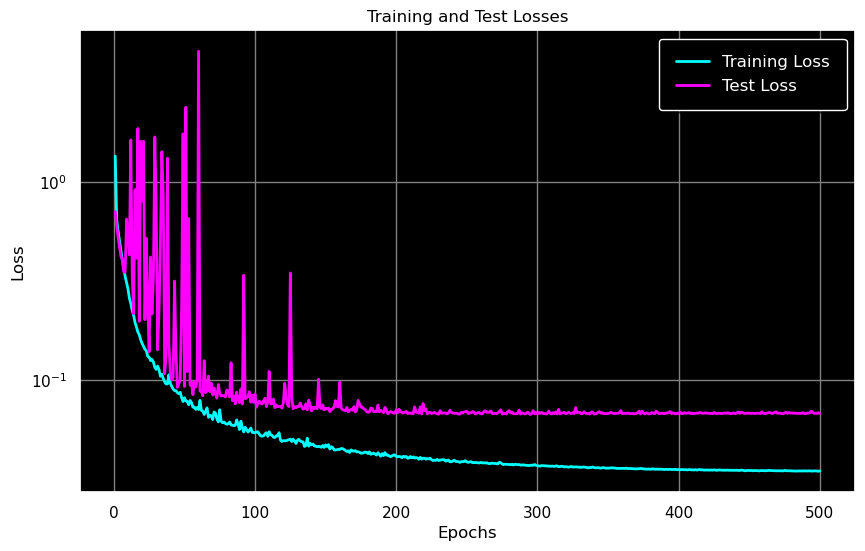

In [ ]:
"""
Plotting training and validation losses
"""


import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

base_folder='/hpc/group/youlab/ks723/miniconda3/saved_models/logs'
filename='losses_Pixel_32x32x3to32x32x4_dilRESNET_30k_newpatterns_seedtointermediate__Model_v1113_Cluster_GPU_tfData-1731542355.json'


file=os.path.join(base_folder,filename)

# Load the JSON file later if needed
with open(file, "r") as f:
    data = json.load(f)


# Extract train_losses and test_losses
train_losses = data.get('train_losses', [])
test_losses = data.get('test_losses', [])

# Print the extracted losses
print("Train Losses:", train_losses)
print("Test Losses:", test_losses)


# Function to plot training and test losses with custom style
def plot_losses(train_losses, test_losses):
    sns.set(style='darkgrid', rc={"axes.facecolor": "black", "grid.color": "grey"})  # Setting the style
    plt.figure(figsize=(10, 6))
    
    epochs = np.arange(1, len(train_losses) + 1)  # Assuming train_losses and test_losses are of the same length
    
    plt.plot(epochs, train_losses, label='Training Loss', color='cyan', linewidth=2)  # Thicker line for Training Loss
    plt.plot(epochs, test_losses, label='Test Loss', color='magenta', linewidth=2)  # Thicker line for Test Loss
    
    plt.title('Training and Test Losses', color='black')
    plt.xlabel('Epochs', color='black')
    plt.ylabel('Loss', color='black')
    plt.yscale('log')  # Set y-axis to log scale
    
    plt.tick_params(axis='x', colors='black')  # Change tick color to white
    plt.tick_params(axis='y', colors='black')  # Change tick color to white
    
    plt.legend(facecolor='black', edgecolor='white', fontsize='medium', fancybox=True, framealpha=1, shadow=True, borderpad=1, labelcolor='white')
    plt.show()

# Make sure to call this function after the training loop
plot_losses(train_losses, test_losses)



